###  프로젝트 개요

본 프로젝트는 Apple Inc. (AAPL)의 주가 데이터를 활용하여, 과거 주가 흐름 및 기술적 분석 지표를 바탕으로 **실적 발표 이후의 하락/상승장을 예측**하는 시계열 머신러닝 모델을 개발하는 것을 목표로 합니다.


###  문제 정의

애플(AAPL)의 실적 발표는 주가에 직접적인 영향을 미치는 주요 이벤트입니다. 하지만 시장 반응은 일정하지 않고 다양한 요인(기술적 흐름, 수급, 기대감 등)에 따라 달라지기 때문에, **실적 발표 이후 수익률을 사전에 예측하는 것은 어려운 문제**입니다.

본 프로젝트는 이를 해결하기 위해 다음과 같은 문제를 설정합니다:

- 실적 발표일을 기준으로 기술적 지표를 사용하여
  이후 주가 변화(상승/하락장)을 예측할 수 있는가?

###  프로젝트 목표

1. Yahoo Finance를 활용하여 애플의 주가 및 실적 발표 데이터 수집
2. 기술적 지표(RSI, ROC, MA, EMA 등) 기반 Feature Engineering
3. LSTM, XGBoost, LinearRegression 등 다양한 모델을 적용하여 예측
4. RMSE, R² 등의 성능지표 기반 평가 및 시각화
5. 성능이 우수한 모델을 `.h5` 파일로 저장 및 배포(Deploy) 고려

---

다음 셀에서는 데이터 로딩 및 전처리를 수행합니다.

In [1]:
!wget https://raw.githubusercontent.com/cknd/pyESN/master/pyESN.py

--2025-06-17 04:24:23--  https://raw.githubusercontent.com/cknd/pyESN/master/pyESN.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10789 (11K) [text/plain]
Saving to: ‘pyESN.py’

pyESN.py            100%[===================>]  10.54K  --.-KB/s    in 0s      

2025-06-17 04:24:23 (104 MB/s) - ‘pyESN.py’ saved [10789/10789]



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cd /content/drive/MyDrive/ts_data

In [4]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 11.5 MB/s eta 0:00:00


In [5]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from deap import base, creator, tools, algorithms
import random

In [6]:
df_price = pd.read_excel("/content/drive/MyDrive/ts_data/AAPL_price_2010_2025.xlsx")

In [7]:
df_price.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-01-04,6.414465,6.446623,6.382908,6.431896,493729600,0.0,0
1,2010-01-05,6.449628,6.479381,6.409054,6.443016,601904800,0.0,0
2,2010-01-06,6.443018,6.468564,6.333921,6.340533,552160000,0.0,0
3,2010-01-07,6.363974,6.371488,6.282828,6.328811,477131200,0.0,0
4,2010-01-08,6.320396,6.371489,6.283130,6.370887,447610800,0.0,0


In [8]:
# 2. 실적 발표 데이터: 엑셀 파일로 대체
df_earnings = pd.read_excel("/content/drive/MyDrive/ts_data/10to25_AAPL_Earning_Data.xlsx")
df_earnings["Earnings Date"] = pd.to_datetime(df_earnings["Earnings Date"])
# 날짜 형식을 'YYYY-MM-DD' 문자열로 변환
df_earnings["Earnings Date"] = df_earnings["Earnings Date"].dt.date

df_earnings_save = df_earnings

print(" 주가 데이터:", df_price.shape)
print(" 실적 발표 데이터:", df_earnings.shape)

 주가 데이터: (3774, 8)
 실적 발표 데이터: (66, 4)


In [9]:
df_earnings.tail(10)

,Earnings Date,EPS Estimate,Reported EPS,Surprise(%)
56,2012-04-24,0.36,0.44,22.56
57,2012-01-24,0.36,0.50,36.46
58,2011-10-18,0.26,0.25,-4.54
59,2011-07-19,0.21,0.28,33.58
60,2011-04-20,0.19,0.23,19.09
61,2011-01-18,0.19,0.23,19.03
62,2010-10-18,0.15,0.17,13.65
63,2010-07-20,0.11,0.13,12.68
64,2010-04-20,0.09,0.12,36.11
65,2010-01-25,0.07,0.13,76.00


In [10]:
df_price.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0


In [11]:
df_earnings.isnull().sum()
#불필요한 칼럼 다수 및 결측지 확인

,0
Earnings Date,0
EPS Estimate,4
Reported EPS,4
Surprise(%),4


In [12]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def compute_roc(series, period=10):
    return (series - series.shift(period)) / series.shift(period) * 100

In [13]:
# PreProcessing
# 1. 필요한 컬럼만 추출
cols_needed = ["Earnings Date", "Reported EPS", "EPS Estimate", "Surprise(%)"]
df_earnings = df_earnings[cols_needed].copy()

# 2. 실적 데이터 타입 및 인덱스 설정 (중복 제거 포함)
df_earnings["Earnings Date"] = pd.to_datetime(df_earnings["Earnings Date"], errors='coerce')
df_earnings = df_earnings.dropna(subset=["Earnings Date"])  # 날짜형 변환 실패 제거
df_earnings = df_earnings.drop_duplicates(subset="Earnings Date")
df_earnings = df_earnings.sort_values(by="Earnings Date").reset_index(drop=True)

In [14]:
# 3. 실적 데이터 Up Sampling (일 단위로 확장, forward fill)
df_earnings.set_index("Earnings Date", inplace=True)
df_earnings = df_earnings.resample('D').ffill()

실적 발표 후 (a) 다음 실적 발표까지 (b) 의 기간동안 (a)의 값이 주가 데이터에 영향을 끼친다는 가정하에 코딩

In [15]:
# 4. 주가 데이터 결측치 처리
# 기본적으로 forward fill 적용 후 남은 결측치는 선형 보간으로 보완
if df_price.isna().sum().sum() > 0:
    df_price.ffill(inplace=True)
    if df_price.isna().sum().sum() > 0:
        df_price.interpolate(method='linear', inplace=True)

In [16]:
# 5. 지수 평활화(Exponential Smoothing) 적용
alpha = 0.2
df_price["Close_smooth"] = df_price["Close"].ewm(alpha=alpha).mean()
df_price["Volume_smooth"] = df_price["Volume"].ewm(alpha=alpha).mean()

In [17]:
# 6. 기술 지표 계산용 함수 정의 및 적용

df_price["RSI_smooth"] = compute_rsi(df_price["Close_smooth"])
df_price["ROC_smooth"] = compute_roc(df_price["Close_smooth"])

# 7. 기술 지표 계산 후 생길 수 있는 NaN 제거 및 소수점 반올림
df_price.dropna(inplace=True)
df_price = df_price.round(2)

In [18]:
# 8. 실적 이상치 제거 (Surprise % 기준)
df_earnings = df_earnings[df_earnings["Surprise(%)"].between(-100, 100)]

# 9. 정렬 및 확인
df_price.sort_index(inplace=True)
df_earnings.sort_index(inplace=True)

# 10. 상태 확인 출력
print(" df_price 결측치:", df_price.isna().sum().sum())
print(" df_earnings 결측치:", df_earnings.isna().sum().sum())

 df_price 결측치: 0
 df_earnings 결측치: 0


In [19]:
df_earnings.head()

,Reported EPS,EPS Estimate,Surprise(%)
Earnings Date,,,
2010-01-25,0.13,0.07,76.0
2010-01-26,0.13,0.07,76.0
2010-01-27,0.13,0.07,76.0
2010-01-28,0.13,0.07,76.0
2010-01-29,0.13,0.07,76.0


In [20]:
df_price.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_smooth,Volume_smooth,RSI_smooth,ROC_smooth
13,2010-01-22,6.21,6.24,5.93,5.94,881767600,0.0,0,6.24,6.500507e+08,17.51,-2.11
14,2010-01-25,6.09,6.15,6.02,6.10,1065699600,0.0,0,6.21,7.362120e+08,15.97,-2.54
15,2010-01-26,6.19,6.42,6.09,6.19,1867110000,0.0,0,6.21,9.689424e+08,14.12,-2.37
16,2010-01-27,6.22,6.33,6.00,6.25,1722568400,0.0,0,6.22,1.123140e+09,18.52,-1.79
17,2010-01-28,6.16,6.18,5.97,5.99,1173502400,0.0,0,6.17,1.133397e+09,17.19,-2.52


In [21]:
#EDA
print(df_price.describe())

                                Date         Open         High          Low  \
count                           3761  3761.000000  3761.000000  3761.000000   
mean   2017-07-11 08:00:53.602765056    67.588094    68.300165    66.918745   
min              2010-01-22 00:00:00     5.780000     5.890000     5.720000   
25%              2013-10-16 00:00:00    17.570000    17.710000    17.390000   
50%              2017-07-12 00:00:00    35.630000    35.870000    35.290000   
75%              2021-04-07 00:00:00   126.640000   128.290000   125.280000   
max              2024-12-31 00:00:00   257.570000   259.470000   257.010000   
std                              NaN    65.452396    66.140162    64.833452   

             Close        Volume    Dividends  Stock Splits  Close_smooth  \
count  3761.000000  3.761000e+03  3761.000000   3761.000000   3761.000000   
mean     67.644579  2.287971e+08     0.002313      0.002925     67.382768   
min       5.770000  2.323470e+07     0.000000      0.0000

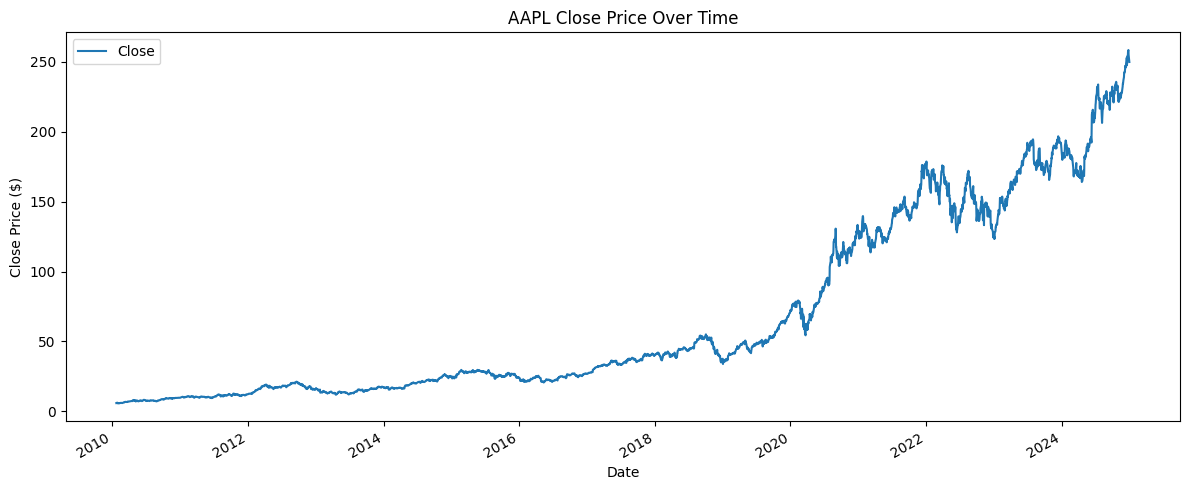

In [22]:
# 종가 추세
df_price.reset_index().plot(x="Date", y="Close", figsize=(12, 5), title="AAPL Close Price Over Time")
plt.ylabel("Close Price ($)")
plt.tight_layout()
plt.show()

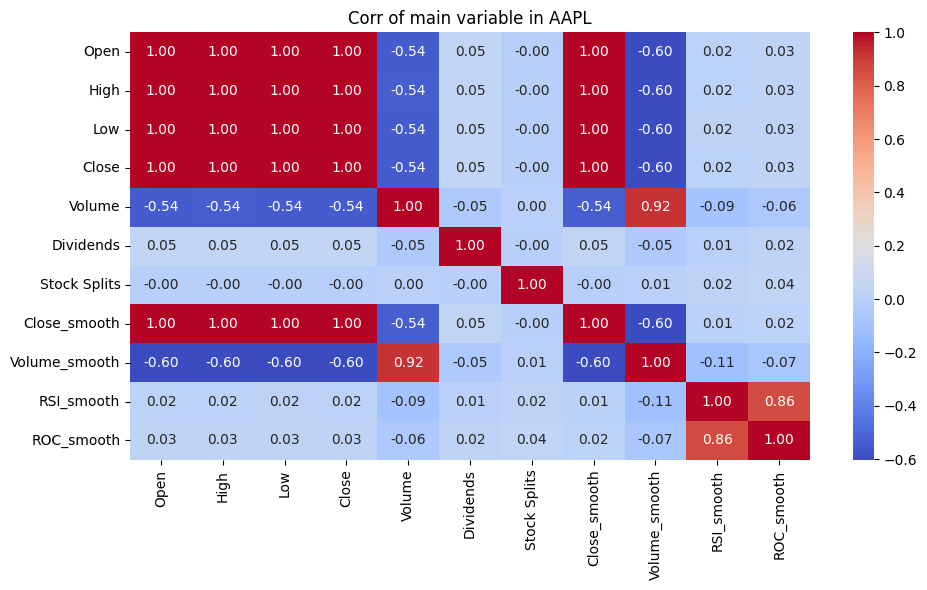

In [23]:
# 상관관계 히트맵
plt.figure(figsize=(10, 6))
sns.heatmap(df_price.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Corr of main variable in AAPL")
plt.tight_layout()
plt.show()

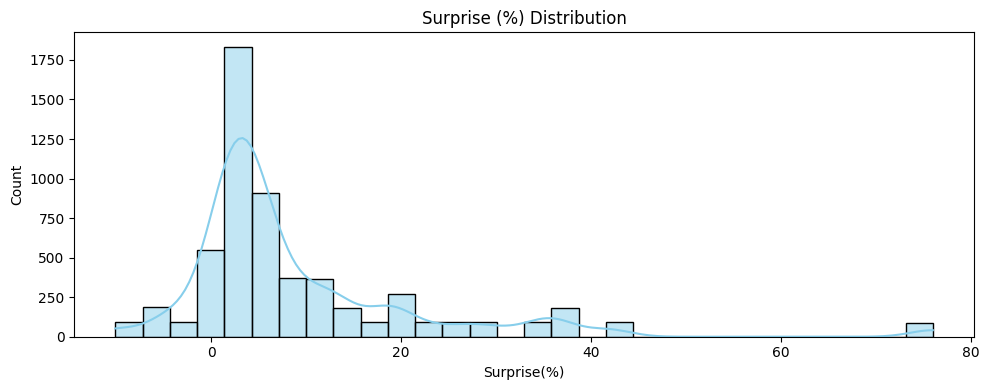

In [24]:
# Surprise (%) 분포

plt.figure(figsize=(10, 4))
sns.histplot(df_earnings["Surprise(%)"], bins=30, kde=True, color="skyblue")
plt.title("Surprise (%) Distribution")
plt.xlabel("Surprise(%)")
plt.tight_layout()
plt.show()

1. 종가 추세:
   - 2010~2025 기간 동안 AAPL 종가는 전반적으로 상승하는 추세를 보입니다.
   - 특히 2020 이후 큰 폭의 상승과 변동성이 관측됩니다.

2.  상관관계 히트맵:
   - Close, Close_smooth, RSI_smooth, ROC_smooth 간에 높은 상관성이 관찰됩니다.
   - Volume_smooth는 가격 계열과 비교적 낮은 상관을 보이며 독립 Feature로 활용 가능성이 있습니다.

3. Surprise (%) 분포:
   - 대체로 +10% ~ +20% 사이가 가장 많으며, 전반적으로 양(+)의 Surprise가 많습니다.
   - 이는 실적 발표가 시장 예상치를 상회하는 경우가 많음을 뜻합니다.

In [25]:
#Feature Engineering(TA 지표들)
# 기본 이동 평균선
for window in [5, 10, 20]:
    df_price[f"MA_{window}"] = df_price["Close"].rolling(window=window).mean()

# Stochastic Oscillator (%K, %D)
df_price['Low14'] = df_price['Low'].rolling(window=14).min()
df_price['High14'] = df_price['High'].rolling(window=14).max()
df_price['%K'] = (df_price['Close'] - df_price['Low14']) / (df_price['High14'] - df_price['Low14']) * 100
df_price['%D'] = df_price['%K'].rolling(window=3).mean()

# MACD (12,26 EMA and Signal)
df_price['EMA12'] = df_price['Close'].ewm(span=12, adjust=False).mean()
df_price['EMA26'] = df_price['Close'].ewm(span=26, adjust=False).mean()
df_price['MACD'] = df_price['EMA12'] - df_price['EMA26']
df_price['Signal'] = df_price['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands (20-day SMA ± 2 std)
df_price['MA20'] = df_price['Close'].rolling(window=20).mean()
df_price['BB_upper'] = df_price['MA20'] + 2 * df_price['Close'].rolling(window=20).std()
df_price['BB_lower'] = df_price['MA20'] - 2 * df_price['Close'].rolling(window=20).std()

# Volume Change %
df_price['Volume_change'] = df_price['Volume'].pct_change() * 100

# 기타 기본 지표
df_price["RSI_smooth"] = compute_rsi(df_price["Close_smooth"])
df_price["ROC_smooth"] = compute_roc(df_price["Close_smooth"])

df_price.dropna(inplace=True)
df_price = df_price.round(2)

df_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3742 entries, 32 to 3773
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           3742 non-null   datetime64[ns]
 1   Open           3742 non-null   float64       
 2   High           3742 non-null   float64       
 3   Low            3742 non-null   float64       
 4   Close          3742 non-null   float64       
 5   Volume         3742 non-null   int64         
 6   Dividends      3742 non-null   float64       
 7   Stock Splits   3742 non-null   int64         
 8   Close_smooth   3742 non-null   float64       
 9   Volume_smooth  3742 non-null   float64       
 10  RSI_smooth     3742 non-null   float64       
 11  ROC_smooth     3742 non-null   float64       
 12  MA_5           3742 non-null   float64       
 13  MA_10          3742 non-null   float64       
 14  MA_20          3742 non-null   float64       
 15  Low14          3742 non-n

## Feature Engineering: 기술적 지표 설명
### 1. 이동 평균선 (Moving Averages)
MA_5, MA_10, MA_20

  *  최근 5일, 10일, 20일 동안의 종가 평균을 계산한 단순 이동 평균선 (SMA).


###2. GDC (Golden Cross / Dead Cross)
* 1: 골든 크로스 (단기 이동평균선 MA_5가 장기 MA_20을 상향 돌파)

* -1: 데드 크로스 (단기 이동평균선 MA_5가 장기 MA_20을 하향 돌파)

* 0: 변화 없음


###3. Stochastic Oscillator (%K, %D)

1. Low14, High14: 최근 14일간의 최저가 및 최고가

2. %K: 현재 종가가 14일 고저 범위 내에서 어디쯤 위치하는지를 나타냄
(%K = (Close - Low14) / (High14 - Low14) * 100)

3. %D: %K의 3일 단순 이동 평균. %K에 비해 더 부드러운 신호선으로 사용됨.

* **과매수/과매도 판단 기준: 일반적으로 %K 또는 %D가 80 이상이면 과매수, 20 이하면 과매도 가능성.**

### 4. MACD (Moving Average Convergence Divergence)

1. EMA12: 12일 지수 이동 평균

2. EMA26: 26일 지수 이동 평균

3. MACD: EMA12 - EMA26, 단기 추세와 장기 추세 간의 차이

4. Signal: MACD의 9일 지수 이동 평균으로, 신호선 역할을 함

* **MACD > Signal은 매수, < Signal은 매도 신호로 해석될 수 있음.**

### 5. Bollinger Bands

1. MA20: 20일 단순 이동 평균 (기준선)

2. BB_upper: MA20 + 2 * 표준편차, 상단 밴드

3. BB_lower: MA20 - 2 * 표준편차, 하단 밴드

* **주가가 상단 밴드를 돌파하면 과매수, 하단 밴드 돌파 시 과매도 상태일 수 있음.**

### 6. Volume Change (%)
* Volume_change: 전일 대비 거래량의 변화율 (%)




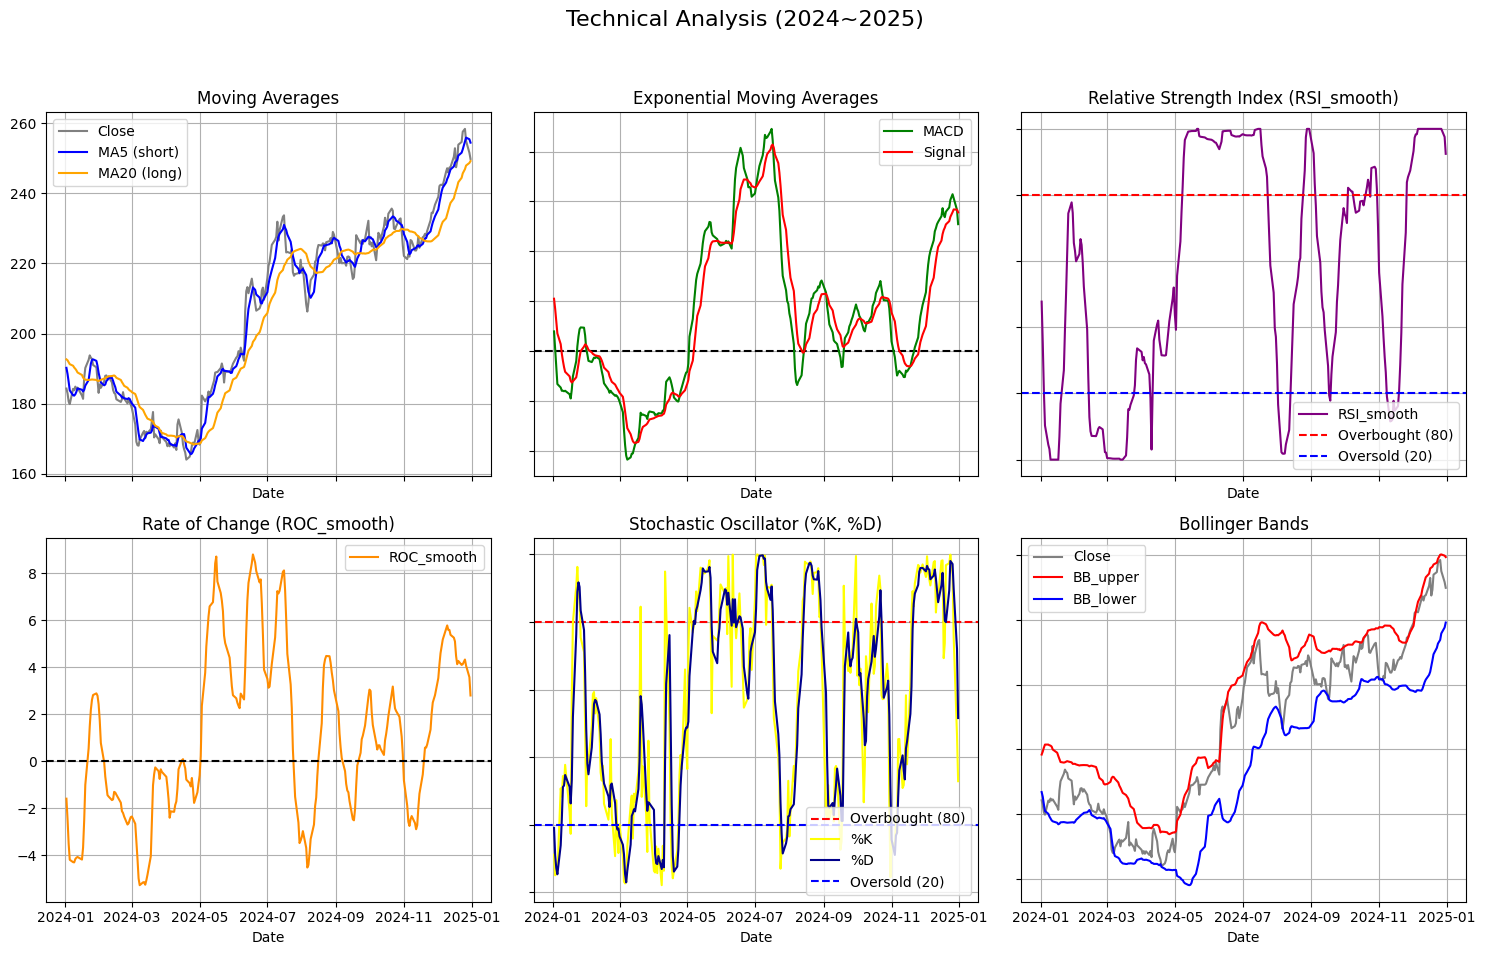

In [26]:
#기술적 지표들을 시각화
#날짜 필터링: 2024년 ~ 2025년
df_plot = df_price[(df_price['Date'] >= '2024-01-01') & (df_price['Date'] <= '2025-01-01')]
df_plot.set_index('Date', inplace=True)

#Figure 생성
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Technical Analysis (2024~2025)', fontsize=16)

# --- (1) MA ---
axs[0, 0].plot(df_plot.index, df_plot['Close'], label='Close', color='gray')
axs[0, 0].plot(df_plot.index, df_plot['MA_5'], label='MA5 (short)', color='blue')
axs[0, 0].plot(df_plot.index, df_plot['MA_20'], label='MA20 (long)', color='orange')
axs[0, 0].set_title('Moving Averages')
axs[0, 0].legend()
axs[0, 0].grid(True)

# --- (2) MACD and Signal ---
axs[0, 1].axhline(0, color='black', linestyle='--') #0 기준 선
axs[0, 1].plot(df_plot.index, df_plot['MACD'], label='MACD', color='green')
axs[0, 1].plot(df_plot.index, df_plot['Signal'], label='Signal', color='red')
axs[0, 1].set_title('Exponential Moving Averages')
axs[0, 1].legend()
axs[0, 1].grid(True)

# --- (3) RSI_smooth ---
axs[0, 2].plot(df_plot.index, df_plot['RSI_smooth'], label='RSI_smooth', color='purple')
axs[0, 2].axhline(80, color='red', linestyle='--', label='Overbought (80)')
axs[0, 2].axhline(20, color='blue', linestyle='--', label='Oversold (20)')
axs[0, 2].set_title('Relative Strength Index (RSI_smooth)')
axs[0, 2].legend()
axs[0, 2].grid(True)

# --- (4) ROC_smooth ---
axs[1, 0].plot(df_plot.index, df_plot['ROC_smooth'], label='ROC_smooth', color='darkorange')
axs[1, 0].axhline(0, color='black', linestyle='--') #0 기준 선
axs[1, 0].set_title('Rate of Change (ROC_smooth)')
axs[1, 0].legend()
axs[1, 0].grid(True)

# --- (5) Stochastic Oscillator (%K, %D) ---
axs[1, 1].axhline(80, color='red', linestyle='--', label='Overbought (80)')
axs[1, 1].plot(df_plot.index, df_plot['%K'], label='%K', color='yellow')
axs[1, 1].plot(df_plot.index, df_plot['%D'], label='%D', color='darkblue')
axs[1, 1].axhline(20, color='blue', linestyle='--', label='Oversold (20)')
axs[1, 1].set_title('Stochastic Oscillator (%K, %D)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# --- (6) Bollinger Bands (20-day SMA ± 2 std) ---
axs[1, 2].plot(df_plot.index, df_plot['Close'], label='Close', color='gray')
axs[1, 2].plot(df_plot.index, df_plot['BB_upper'], label='BB_upper', color='red')
axs[1, 2].plot(df_plot.index, df_plot['BB_lower'], label='BB_lower', color='blue')
axs[1, 2].set_title('Bollinger Bands')
axs[1, 2].legend()
axs[1, 2].grid(True)

# --- 공통 설정 ---
for ax in axs.flat:
    ax.label_outer()  # x축, y축 겹침 최소화
    ax.set_xlabel('Date')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 전체 제목 공간 확보
plt.show()


In [27]:
#기술적 지표 매매신호 추출

#GDC
# MA_GDC: Golden Cross / Dead Cross (MA_5 vs MA_20)
df_price['MA_GDC'] = 0
MA_cross_up = (df_price['MA_5'] > df_price['MA_20']) & (df_price['MA_5'].shift(1) <= df_price['MA_20'].shift(1))
MA_cross_down = (df_price['MA_5'] < df_price['MA_20']) & (df_price['MA_5'].shift(1) >= df_price['MA_20'].shift(1))
df_price.loc[MA_cross_up, 'MA_GDC'] = 1  # Golden Cross
df_price.loc[MA_cross_down, 'MA_GDC'] = -1  # Dead Cross

# SO_GDC: Golden Cross / Dead Cross (K% vs D%)
df_price['SO_GDC'] = 0
SO_cross_up = (df_price['%K'] > df_price['%D']) & (df_price['%K'].shift(1) <= df_price['%D'].shift(1))
SO_cross_down = (df_price['%K'] < df_price['%D']) & (df_price['%K'].shift(1) >= df_price['%D'].shift(1))
df_price.loc[SO_cross_up, 'SO_GDC'] = 1  # Golden Cross
df_price.loc[SO_cross_down, 'SO_GDC'] = -1  # Dead Cross

# MACD_GDC: Golden Cross / Dead Cross (MACD vs Signal)
MACD_cross_up = (df_price['MACD'] > df_price['Signal']) & (df_price['MACD'].shift(1) <= df_price['Signal'].shift(1))
MACD_cross_down = (df_price['MACD'] < df_price['Signal']) & (df_price['MACD'].shift(1) >= df_price['Signal'].shift(1))
df_price['MACD_GDC'] = 0
df_price.loc[MACD_cross_up, 'MACD_GDC'] = 1
df_price.loc[MACD_cross_down, 'MACD_GDC'] = -1

# ROC_buy/sell_Signal
ROC_buy_signal=(df_price['ROC_smooth'].shift(1) < 0) & (df_price['ROC_smooth'] > 0)
ROC_sell_signal=(df_price['ROC_smooth'].shift(1) > 0) & (df_price['ROC_smooth'] < 0)
df_price['ROC_GDC'] = 0
df_price.loc[ROC_buy_signal, 'ROC_GDC'] = 1
df_price.loc[ROC_sell_signal, 'ROC_GDC'] = -1


#과매수(overbought), 과매도(oversold)
#SO_overbought/oversold
SO_overbought = (df_price['%K']>80) & (df_price['%D']>80)
SO_oversold = (df_price['%K']<20) & (df_price['%D']<20)
df_price['SO_momentum'] = 0
df_price.loc[SO_overbought, 'SO_momentum'] = -1
df_price.loc[SO_oversold, 'SO_momentum'] = 1

#Bollinger Bands
BB_overbought = df_price['Close'] > df_price['BB_upper']
BB_oversold = df_price['Close'] < df_price['BB_lower']
df_price['BB_momentum'] = 0
df_price.loc[BB_overbought, 'BB_momentum'] = -1
df_price.loc[BB_oversold, 'BB_momentum'] = 1

#RSI_overbought/oversold
RSI_overbought = (df_price['RSI_smooth']>80)
RSI_oversold = (df_price['RSI_smooth']<20)
df_price['RSI_momentum'] = 0
df_price.loc[RSI_overbought, 'RSI_momentum'] = -1
df_price.loc[RSI_oversold, 'RSI_momentum'] = 1

#ROC_overbought/oversold
ROC_overbought = (df_price['RSI_smooth']>10)
ROC_oversold = (df_price['RSI_smooth']<-10)
df_price['ROC_momentum'] = 0
df_price.loc[SO_overbought, 'ROC_momentum'] = -1
df_price.loc[SO_oversold, 'ROC_momentum'] = 1

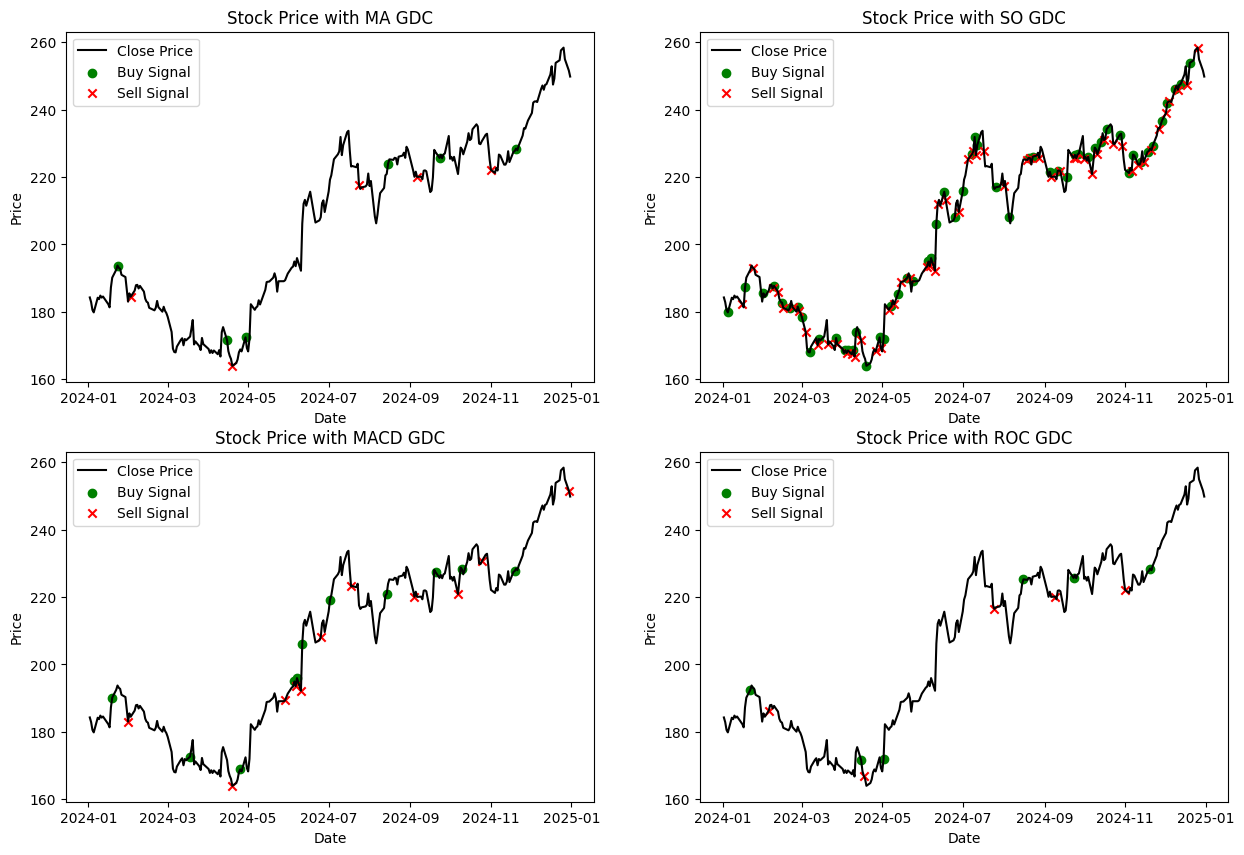

In [28]:
#매매신호 시각화

df_sig = df_price[(df_price['Date'] >= '2024-01-01') & (df_price['Date'] <= '2025-01-01')]
df_sig.set_index('Date', inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

#MA_GDC
axs[0, 0].plot(df_sig.index, df_sig['Close'], label='Close Price', color='black')
buy_ma_signals = df_sig[df_sig['MA_GDC'] == 1]   #매수 신호
sell_ma_signals = df_sig[df_sig['MA_GDC'] == -1] #매도 신호
axs[0, 0].scatter(buy_ma_signals.index, buy_ma_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[0, 0].scatter(sell_ma_signals.index, sell_ma_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[0, 0].set_title('Stock Price with MA GDC')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')
axs[0, 0].legend()

#SO_GDC
axs[0, 1].plot(df_sig.index, df_sig['Close'], label='Close Price', color='black')
buy_so_signals = df_sig[df_sig['SO_GDC'] == 1]   #매수 신호
sell_so_signals = df_sig[df_sig['SO_GDC'] == -1] #매도 신호
axs[0, 1].scatter(buy_so_signals.index, buy_so_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[0, 1].scatter(sell_so_signals.index, sell_so_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[0, 1].set_title('Stock Price with SO GDC')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')
axs[0, 1].legend()

#MACD_GDC
axs[1, 0].plot(df_sig.index, df_sig['Close'], label='Close Price', color='black')
buy_macd_signals = df_sig[df_sig['MACD_GDC'] == 1]   #매수 신호
sell_macd_signals = df_sig[df_sig['MACD_GDC'] == -1] #매도 신호
axs[1, 0].scatter(buy_macd_signals.index, buy_macd_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[1, 0].scatter(sell_macd_signals.index, sell_macd_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[1, 0].set_title('Stock Price with MACD GDC')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Price')
axs[1, 0].legend()

#ROC_GDC
axs[1, 1].plot(df_sig.index, df_sig['Close'], label='Close Price', color='black')
buy_ROC_signals = df_sig[df_sig['ROC_GDC'] == 1]   #매수 신호
sell_ROC_signals = df_sig[df_sig['ROC_GDC'] == -1] #매도 신호
axs[1, 1].scatter(buy_ROC_signals.index, buy_ROC_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[1, 1].scatter(sell_ROC_signals.index, sell_ROC_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[1, 1].set_title('Stock Price with ROC GDC')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price')
axs[1, 1].legend()

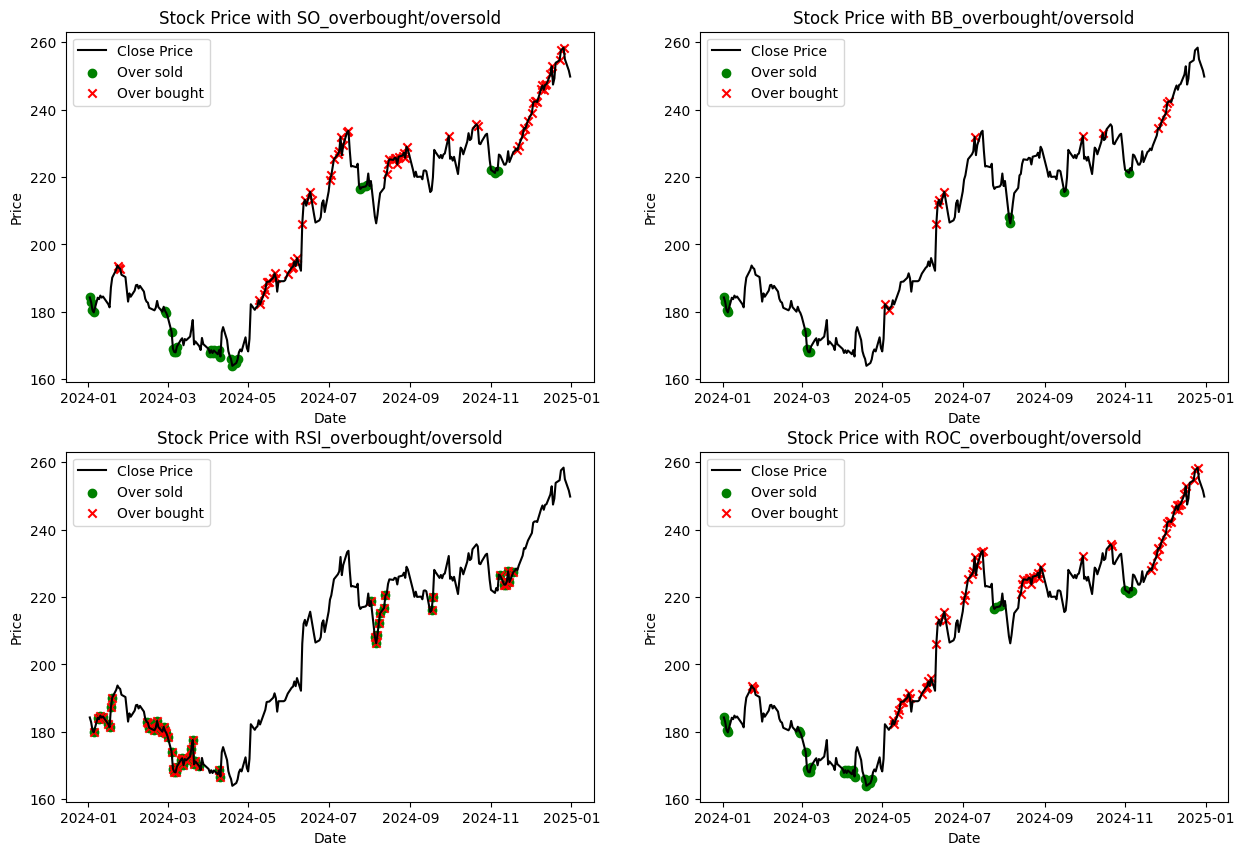

In [29]:
#과매수 과매도 시각화

df_sig = df_price[(df_price['Date'] >= '2024-01-01') & (df_price['Date'] <= '2025-01-01')]
df_sig.set_index('Date', inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

#SO_overbought/oversold
axs[0, 0].plot(df_sig.index, df_sig['Close'], label='Close Price', color='black')
so_oversold = df_sig[df_sig['SO_momentum'] == 1]   #과매도
so_overbought = df_sig[df_sig['SO_momentum'] == -1] #과매수
axs[0, 0].scatter(so_oversold.index, so_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[0, 0].scatter(so_overbought.index, so_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[0, 0].set_title('Stock Price with SO_overbought/oversold')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')
axs[0, 0].legend()

#Bollinger Bands
axs[0, 1].plot(df_sig.index, df_sig['Close'], label='Close Price', color='black')
bb_oversold = df_sig[df_sig['BB_momentum'] == 1]   #과매도
bb_overbought = df_sig[df_sig['BB_momentum'] == -1] #과매수
axs[0, 1].scatter(bb_oversold.index, bb_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[0, 1].scatter(bb_overbought.index, bb_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[0, 1].set_title('Stock Price with BB_overbought/oversold')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')
axs[0, 1].legend()

#RSI_overbought/oversold
axs[1, 0].plot(df_sig.index, df_sig['Close'], label='Close Price', color='black')
rsi_oversold = df_sig[df_sig['RSI_momentum'] == 1]   #과매도
rsi_overbought = df_sig[df_sig['RSI_momentum'] == -1] #과매수
axs[1, 0].scatter(rsi_oversold.index, rsi_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[1, 0].scatter(rsi_oversold.index, rsi_oversold['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[1, 0].set_title('Stock Price with RSI_overbought/oversold')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Price')
axs[1, 0].legend()

#ROC_overbought/oversold
axs[1, 1].plot(df_sig.index, df_sig['Close'], label='Close Price', color='black')
roc_oversold = df_sig[df_sig['ROC_momentum'] == 1]   #과매도
roc_overbought = df_sig[df_sig['ROC_momentum'] == -1] #과매수
axs[1, 1].scatter(roc_oversold.index, roc_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[1, 1].scatter(roc_overbought.index, roc_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[1, 1].set_title('Stock Price with ROC_overbought/oversold')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price')
axs[1, 1].legend()

In [30]:
df_price = df_price.copy()
df_price.reset_index(inplace=True)

df_earnings = df_earnings.copy()
df_earnings.reset_index(inplace=True)
df_earnings.rename(columns={"Earnings Date": "Date"}, inplace=True)

df_price.sort_values("Date", inplace=True)
df_earnings.sort_values("Date", inplace=True)

#df_earnings와 df_price 병합
df_merged = pd.merge_asof(df_price, df_earnings, on="Date", direction="backward")

# 다시 날짜 인덱스 설정
df_merged.set_index("Date", inplace=True)

# 확인
print(" 병합 후 shape:", df_merged.shape)
df_merged.head()


 병합 후 shape: (3742, 38)


,index,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_smooth,Volume_smooth,...,SO_GDC,MACD_GDC,ROC_GDC,SO_momentum,BB_momentum,RSI_momentum,ROC_momentum,Reported EPS,EPS Estimate,Surprise(%)
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-19,32,6.07,6.11,6.04,6.06,415469600,0.0,0,6.03,5.320239e+08,...,0,0,0,0,0,0,0,0.13,0.07,76.0
2010-02-22,33,6.08,6.09,5.99,6.02,390563600,0.0,0,6.03,5.037175e+08,...,0,0,0,0,0,0,0,0.13,0.07,76.0
2010-02-23,34,6.01,6.05,5.88,5.92,575094800,0.0,0,6.00,5.179988e+08,...,0,0,0,0,0,0,0,0.13,0.07,76.0
2010-02-24,35,5.96,6.05,5.95,6.03,460566400,0.0,0,6.01,5.065086e+08,...,1,0,0,0,0,0,0,0.13,0.07,76.0
2010-02-25,36,5.93,6.10,5.92,6.07,665126000,0.0,0,6.02,5.382403e+08,...,0,0,0,0,0,0,0,0.13,0.07,76.0


In [31]:
def make_target(rate):
    if rate > 1:
        return 2  # 상승 - Buy
    elif rate < -1:
        return 0  # 하락 - Sell
    else:
        return 1  # 유지 - Hold

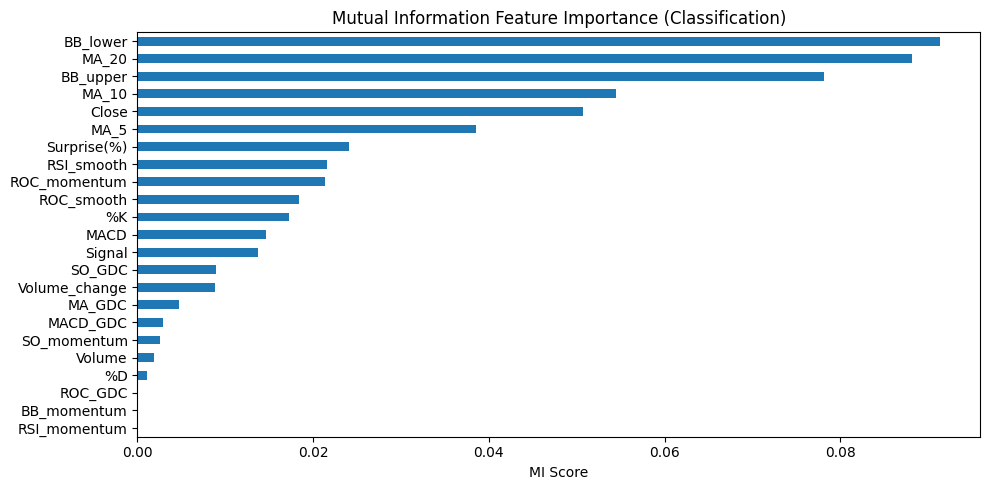

In [32]:
from sklearn.feature_selection import mutual_info_classif

# 1. 타겟 변수 정의 (이미 됨)
df_merged["target_return_3d"] = (df_merged["Close"].shift(-3) - df_merged["Close"]) / df_merged["Close"] * 100
df_merged["target"] = df_merged["target_return_3d"].apply(make_target)

# 2. Feature 후보
all_features = [
    "Close", "Volume", "MA_5", "MA_10", "MA_20", "%K", "%D",
    "MACD", "Signal", "BB_upper", "BB_lower", "Volume_change",
    "RSI_smooth", "ROC_smooth", "Surprise(%)",
    "MA_GDC", "SO_GDC", "MACD_GDC", "ROC_GDC",
    "SO_momentum", "BB_momentum", "RSI_momentum", "ROC_momentum"
]

# 3. 결측치 제거 및 데이터 준비
df_filtered = df_merged.dropna(subset=all_features + ["target"])
X = df_filtered[all_features]
y = df_filtered["target"]

# 4. Mutual Information 계산
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# 5. 시각화
plt.figure(figsize=(10, 5))
mi_series.plot(kind="barh")
plt.title("Mutual Information Feature Importance (Classification)")
plt.xlabel("MI Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [33]:
top_features = mi_series.head(12).index.tolist()

X = X[top_features]
y = df_filtered["target"]

print("Feature Selection 완료:")
print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())


Feature Selection 완료:
X shape: (3742, 12)
y distribution:
 target
2    1511
1    1154
0    1077
Name: count, dtype: int64


In [34]:
print("선택된 주요 Feature :")
print(top_features)

선택된 주요 Feature :
['BB_lower', 'MA_20', 'BB_upper', 'MA_10', 'Close', 'MA_5', 'Surprise(%)', 'RSI_smooth', 'ROC_momentum', 'ROC_smooth', '%K', 'MACD']


In [35]:
def create_MA_GDC(df, short_w, long_w):
    df['MA_short'] = df['Close'].rolling(window=short_w).mean()
    df['MA_long'] = df['Close'].rolling(window=long_w).mean()
    df['MA_GDC'] = 0
    cross_up = (df['MA_short'] > df['MA_long']) & (df['MA_short'].shift(1) <= df['MA_long'].shift(1))
    cross_down = (df['MA_short'] < df['MA_long']) & (df['MA_short'].shift(1) >= df['MA_long'].shift(1))
    df.loc[cross_up, 'MA_GDC'] = 1
    df.loc[cross_down, 'MA_GDC'] = -1
def create_rsi_momentum(df, period):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    df['RSI_momentum'] = 0
    df.loc[rsi > 80, 'RSI_momentum'] = -1
    df.loc[rsi < 20, 'RSI_momentum'] = 1
def create_roc_GDC_momentum(df, period):
    roc = (df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period) * 100
    df['ROC_GDC'] = 0
    df.loc[(roc.shift(1) < 0) & (roc > 0), 'ROC_GDC'] = 1
    df.loc[(roc.shift(1) > 0) & (roc < 0), 'ROC_GDC'] = -1

    df['ROC_momentum'] = 0
    df.loc[roc > 10, 'ROC_momentum'] = -1
    df.loc[roc < -10, 'ROC_momentum'] = 1
def create_BB_momentum(df, period, std_factor):
    ma = df['Close'].rolling(window=period).mean()
    std = df['Close'].rolling(window=period).std()
    upper = ma + std_factor * std
    lower = ma - std_factor * std

    df['BB_momentum'] = 0
    df.loc[df['Close'] > upper, 'BB_momentum'] = -1
    df.loc[df['Close'] < lower, 'BB_momentum'] = 1
def create_SO_GDC_SO_momentum(df, period):
    low_min = df['Low'].rolling(window=period).min()
    high_max = df['High'].rolling(window=period).max()
    k = (df['Close'] - low_min) / (high_max - low_min) * 100
    d = k.rolling(window=3).mean()

    df['SO_GDC'] = 0
    df.loc[(k > d) & (k.shift(1) <= d.shift(1)), 'SO_GDC'] = 1
    df.loc[(k < d) & (k.shift(1) >= d.shift(1)), 'SO_GDC'] = -1
def create_MACD_GDC(df, short_w, long_w, signal_w):
    ema_short = df['Close'].ewm(span=short_w, adjust=False).mean()
    ema_long = df['Close'].ewm(span=long_w, adjust=False).mean()
    macd = ema_short - ema_long
    signal = macd.ewm(span=signal_w, adjust=False).mean()

    df['MACD_GDC'] = 0
    df.loc[(macd > signal) & (macd.shift(1) <= signal.shift(1)), 'MACD_GDC'] = 1
    df.loc[(macd < signal) & (macd.shift(1) >= signal.shift(1)), 'MACD_GDC'] = -1



In [36]:
# GA 기반 기술적 지표 파라미터 최적화 전체 코드 구성 (MI 기반 Feature 반영)

from deap import base, creator, tools, algorithms
import numpy as np
import random

# --- 1. 파라미터 정의 ---

GENE_NAMES = [
    "ma_short", "ma_long",            # MA_10, MA_20
    "rsi_period",                     # RSI_smooth
    "roc_period",                     # ROC_GDC, ROC_momentum
    "bb_period", "bb_std",            # BB_lower, BB_upper
    "so_k_period",                    # %K
    "macd_short", "macd_long", "macd_signal"  # MACD_GDC
]

BOUNDS = [
    (5, 15), (15, 60),          # MA periods
    (5, 30),                    # RSI period
    (5, 20),                    # ROC period
    (10, 30), (1, 3),           # BB period & std
    (5, 20),                    # Stochastic %K
    (5, 15), (15, 40), (5, 15)  # MACD params
]

# --- 2. 유전자와 toolbox 설정 ---

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
for i, (low, high) in enumerate(BOUNDS):
    toolbox.register(f"gene_{i}", random.randint, low, high)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 [toolbox.__getattribute__(f"gene_{i}") for i in range(len(GENE_NAMES))], n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# --- 3. 신호 생성 함수 (각 파라미터 적용) ---

def apply_signals(df, individual):
    params = dict(zip(GENE_NAMES, map(int, individual)))

    create_MA_GDC(df, params["ma_short"], params["ma_long"])
    create_rsi_momentum(df, params["rsi_period"])
    create_roc_GDC_momentum(df, params["roc_period"])
    create_BB_momentum(df, params["bb_period"], params["bb_std"])
    create_SO_GDC_SO_momentum(df, params["so_k_period"])
    create_MACD_GDC(df, params["macd_short"], params["macd_long"], params["macd_signal"])

    df['signal'] = df[["MA_GDC", "RSI_momentum", "ROC_GDC", "ROC_momentum", "BB_momentum", "SO_GDC", "MACD_GDC"]].sum(axis=1)
    return df

# --- 4. Fitness 평가 함수 ---

def evaluate_individual(individual):
    df_eval = df_merged.copy()
    df_eval = apply_signals(df_eval, individual)

    df_eval['daily_return'] = df_eval['Close'].pct_change().shift(-1)
    df_eval['strategy_return'] = df_eval['signal'].shift(1) * df_eval['daily_return']

    strat = df_eval['strategy_return'].dropna()
    if len(strat) < 30 or strat.std() == 0:
        return (1e6,)  # 비정상 전략 penalty

    sharpe = strat.mean() / strat.std() * np.sqrt(252)
    cumulative = strat.cumsum()
    mdd = (cumulative.cummax() - cumulative).max()

    return (-sharpe + mdd,)

toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt,
                 low=[b[0] for b in BOUNDS],
                 up=[b[1] for b in BOUNDS],
                 indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# --- 5. GA 실행 함수 ---

def run_ga_optimization(n_gen=20, pop_size=30):
    print(f"GA 시작: 세대 {n_gen}, 개체 {pop_size}")
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    stats.register("std", np.std)

    pop, logbook = algorithms.eaSimple(
        pop, toolbox, cxpb=0.5, mutpb=0.3,
        ngen=n_gen, stats=stats, halloffame=hof,
        verbose=True
    )
    best_params = dict(zip(GENE_NAMES, map(int, hof[0])))
    return best_params, logbook



In [37]:
best_params, log = run_ga_optimization(n_gen=50, pop_size=100)
print("최적 파라미터:", best_params)


GA 시작: 세대 50, 개체 100
gen	nevals	avg    	min     	max    	std     
0  	100   	1.98107	0.402421	5.01858	0.985913
1  	64    	1.26269	0.234165	2.93425	0.639183
2  	62    	0.902306	0.233215	3.62563	0.491453
3  	61    	0.64943 	-0.0388803	2.03988	0.387717
4  	64    	0.451369	-0.0725567	2.55537	0.396094
5  	61    	0.329255	-0.0403802	1.57753	0.292986
6  	69    	0.278113	-0.100035 	2.21256	0.403147
7  	62    	0.156148	-0.161446 	1.54593	0.279299
8  	62    	0.105373	-0.172625 	2.60928	0.35307 
9  	72    	0.0560819	-0.172625 	1.3125 	0.256953
10 	58    	-0.0243102	-0.194579 	0.578244	0.153126
11 	63    	0.00224236	-0.26704  	1.77677 	0.32796 
12 	66    	-0.0595353	-0.26704  	1.38086 	0.259399
13 	76    	0.00041031	-0.26704  	1.00526 	0.297162
14 	71    	-0.00341989	-0.26704  	1.96936 	0.39571 
15 	65    	-0.033441  	-0.26704  	1.23434 	0.285198
16 	67    	0.00756767 	-0.250775 	1.446   	0.390651
17 	65    	0.0189611  	-0.324415 	2.66758 	0.460837
18 	60    	-0.0665814 	-0.324415 	1.08312 	0.2804

In [38]:
best_params

{'ma_short': 9,
 'ma_long': 15,
 'rsi_period': 21,
 'roc_period': 9,
 'bb_period': 25,
 'bb_std': 2,
 'so_k_period': 5,
 'macd_short': 6,
 'macd_long': 28,
 'macd_signal': 8}

In [39]:
# 경험 vs GA 전략 비교를 위한 필요한 함수들 전체 정의

# --- Buy and Hold 누적 수익률 ---
def create_buy_and_hold(df):
    df = df.copy()
    df['daily_return'] = df['Close'].pct_change().shift(-1)
    df['cumulative_return'] = (1 + df['daily_return'].fillna(0)).cumprod()
    return df[['cumulative_return']]


# --- 1. 경험적 파라미터 기반 신호 생성 ---
def create_signals_empirical(df):
    df = df.copy()
    create_MA_GDC(df, 5, 20)
    create_rsi_momentum(df, 14)
    create_roc_GDC_momentum(df, 10)
    create_BB_momentum(df, 20, 2)
    create_SO_GDC_SO_momentum(df, 14)
    create_MACD_GDC(df, 12, 26, 9)
    df['signal'] = df[["MA_GDC", "RSI_momentum", "ROC_GDC", "ROC_momentum", "BB_momentum", "SO_GDC", "MACD_GDC"]].sum(axis=1)
    return df

# --- 2. GA 최적 파라미터 기반 신호 생성 ---
def create_signals_ga(df, best_params):
    df = df.copy()
    apply_signals(df, list(best_params.values()))
    return df

# --- 3. 백테스트 함수 ---
def backtest_strategy(df, signal_col, name="전략"):
    df = df.copy()
    df['daily_return'] = df['Close'].pct_change().shift(-1)
    df['strategy_return'] = df[signal_col].shift(1) * df['daily_return']

    # NaN 제거 및 필터링
    strat = df['strategy_return'].dropna()
    if strat.empty or strat.std() == 0:
        return {
            "전략명": name,
            "Sharpe Ratio": np.nan,
            "Max Drawdown": np.nan,
            "Total Return": np.nan
        }, df[['Close']]

    df['cumulative_return'] = (1 + df['strategy_return']).cumprod()
    df['drawdown'] = df['cumulative_return'] / df['cumulative_return'].cummax() - 1

    sharpe = strat.mean() / strat.std() * np.sqrt(252)
    mdd = df['drawdown'].min()
    print(df[['strategy_return', 'cumulative_return']].tail())
    #strategy_return이 nan 값인 날은 매매 신호가 없거나 결측치가 발생한 날로, 그 날은 수익 없음(0%)로 처리
    df['cumulative_return'] = (1 + df['strategy_return'].fillna(0)).cumprod()
    total_return = df['cumulative_return'].dropna().iloc[-1] - 1 if not df['cumulative_return'].dropna().empty else np.nan


    return {
        "전략명": name,
        "Sharpe Ratio": round(sharpe, 3),
        "Max Drawdown": round(abs(mdd), 3),
        "Total Return": round(total_return * 100, 2)
    }, df[['cumulative_return']]

    # --- Buy and Hold 전략 평가 ---
def evaluate_buy_and_hold(df):
    df = df.copy()
    df['daily_return'] = df['Close'].pct_change().shift(-1)
    df['cumulative_return'] = (1 + df['daily_return'].fillna(0)).cumprod()
    df['drawdown'] = df['cumulative_return'] / df['cumulative_return'].cummax() - 1

    strat = df['daily_return'].dropna()
    sharpe = strat.mean() / strat.std() * np.sqrt(252)
    mdd = df['drawdown'].min()
    total_return = df['cumulative_return'].iloc[-1] - 1

    return {
        "전략명": "Buy and Hold",
        "Sharpe Ratio": round(sharpe, 3),
        "Max Drawdown": round(abs(mdd), 3),
        "Total Return": round(total_return * 100, 2)
    }, df[['cumulative_return']]

    # --- 누적 수익률 계산 ---
def compute_strategy_returns(df):
    df['daily_return'] = df['Close'].pct_change().shift(-1)
    df['strategy_return'] = df['signal'].shift(1) * df['daily_return']
    df['cumulative_return'] = (1 + df['strategy_return'].fillna(0)).cumprod()
    return df



In [40]:
df_emp = create_signals_empirical(df_merged)
df_ga = create_signals_ga(df_merged, best_params)

result_emp, cum_emp = backtest_strategy(df_emp, "signal", "경험 전략")
result_ga, cum_ga = backtest_strategy(df_ga, "signal", "GA 최적 전략")

import pandas as pd
result_df = pd.DataFrame([result_emp, result_ga])
print(result_df)


            strategy_return  cumulative_return
Date                                          
2024-12-24         0.000000           2.720392
2024-12-26        -0.000000           2.720392
2024-12-27         0.013256           2.756455
2024-12-30        -0.000000           2.756455
2024-12-31              NaN                NaN
            strategy_return  cumulative_return
Date                                          
2024-12-24        -0.003183          13.022303
2024-12-26         0.013274          13.195161
2024-12-27         0.026513          13.545003
2024-12-30        -0.000000          13.545003
2024-12-31              NaN                NaN
        전략명  Sharpe Ratio  Max Drawdown  Total Return
0     경험 전략         0.375         0.589        175.65
1  GA 최적 전략         0.742         0.336       1254.50


In [41]:
result_hold, cum_hold = evaluate_buy_and_hold(df_merged)

# 결과 통합
result_df = pd.DataFrame([result_emp, result_ga, result_hold])
print(result_df)

            전략명  Sharpe Ratio  Max Drawdown  Total Return
0         경험 전략         0.375         0.589        175.65
1      GA 최적 전략         0.742         0.336       1254.50
2  Buy and Hold         1.040         0.438       4022.44


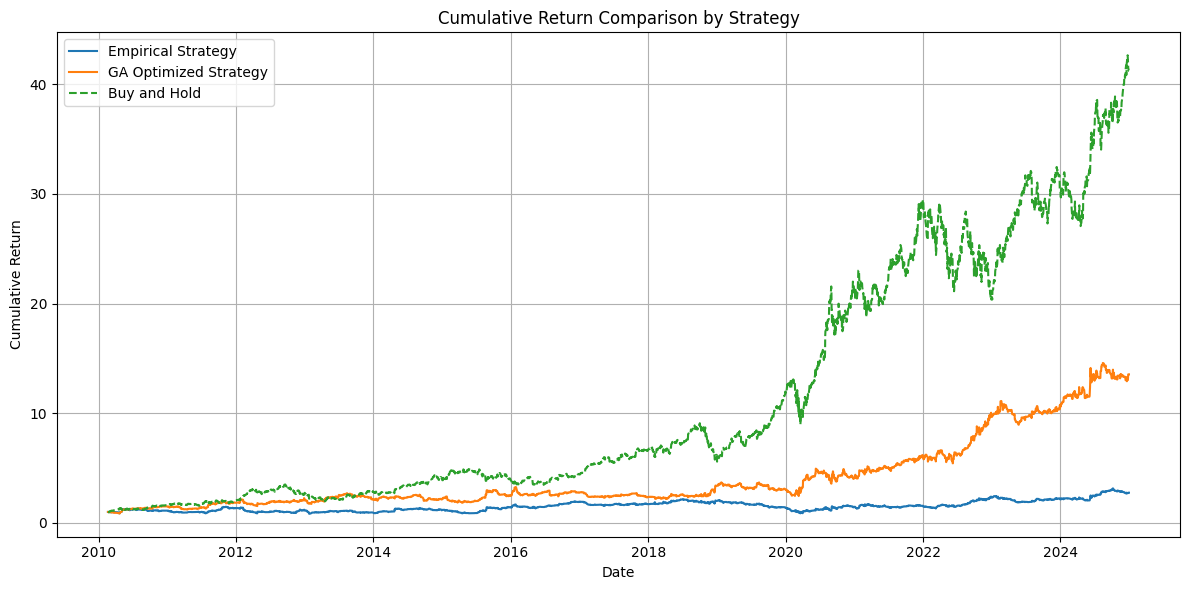

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cum_emp.index, cum_emp['cumulative_return'], label='Empirical Strategy')
plt.plot(cum_ga.index, cum_ga['cumulative_return'], label='GA Optimized Strategy')
plt.plot(cum_hold.index, cum_hold['cumulative_return'], label='Buy and Hold', linestyle='--')

plt.title("Cumulative Return Comparison by Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
df_merged = create_signals_ga(df_merged, best_params)

# 최적화 파라미터로 기존 top_feature에서 추가된 feature들을 top_feature로 넣어봄
top_features = [    "MA_GDC", "RSI_momentum", "ROC_GDC", "ROC_momentum",
    "BB_momentum", "SO_GDC", "MACD_GDC", "signal","Surprise(%)","Close"]
X = df_merged[top_features]
y = df_merged["target"]

In [65]:
from sklearn.model_selection import TimeSeriesSplit

# TimeSeriesSplit 기반 Cross-Validation 분할 (3-class 분류용)
def timeseries_cv_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_splits = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        cv_splits.append({
            "fold": fold + 1,
            "X_train": X_train,
            "X_val": X_val,
            "y_train": y_train,
            "y_val": y_val
        })

    return cv_splits

# 예시 실행
cv_splits = timeseries_cv_split(X, y, n_splits=5)

# Fold 1 출력
fold_1 = cv_splits[0]
print("Fold 1 - Train:", fold_1["X_train"].shape, "Val:", fold_1["X_val"].shape)


Fold 1 - Train: (627, 10) Val: (623, 10)


In [45]:
print(top_features)

['MA_GDC', 'RSI_momentum', 'ROC_GDC', 'ROC_momentum', 'BB_momentum', 'SO_GDC', 'MACD_GDC', 'signal', 'Surprise(%)', 'Close']


In [67]:
from pyESN import ESN
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import itertools

# 시계열 시퀀스 생성
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size].values)
        ys.append(y.iloc[i + window_size])
    return np.array(Xs), np.array(ys)

# ESN 분류 평가
def esn_gridsearch_cv(df,top_features, grid_params, cv_splits, window_size=20):
    X_all = df[top_features]
    y_all = df["target"].astype(int)  # 0/1/2

    results = []
    fold_scores = {}  # 각 파라미터 조합별 fold 정확도 저장용

    keys = list(grid_params.keys())
    combinations = list(itertools.product(*grid_params.values()))

    for combo in combinations:
        param_set = dict(zip(keys, combo))
        fold_acc = []
        fold_f1 = []

        for fold in cv_splits:
            X_train_seq, y_train_seq = create_sequences(fold['X_train'], fold['y_train'], window_size)
            X_val_seq, y_val_seq = create_sequences(fold['X_val'], fold['y_val'], window_size)

            X_train_last = X_train_seq[:, -1, :]
            X_val_last = X_val_seq[:, -1, :]

            esn = ESN(
                n_inputs=X_train_last.shape[1],
                n_outputs=1,
                n_reservoir=param_set['n_reservoir'],
                sparsity=param_set['sparsity'],
                spectral_radius=param_set['spectral_radius'],
                random_state=42
            )

            esn.fit(X_train_last, y_train_seq)
            y_pred = esn.predict(X_val_last)

            y_pred_class = np.clip(np.round(y_pred), 0, 2).astype(int)
            y_true_class = y_val_seq.astype(int)

            acc = accuracy_score(y_true_class, y_pred_class)
            f1 = f1_score(y_true_class, y_pred_class, average="macro")

            fold_acc.append(acc)
            fold_f1.append(f1)

            # 저장
            fold_scores[combo] = fold_acc

        results.append({
            **param_set,
            "avg_accuracy": round(np.mean(fold_acc), 5),
            "avg_f1": round(np.mean(fold_f1), 5)
        })

    return sorted(results, key=lambda x: x["avg_f1"], reverse=True), fold_scores


In [68]:
grid_params = {
    "n_reservoir": [300],
    "sparsity": [0.1239, 0.12393, 0.12395, 0.12398, 0.124],
    "spectral_radius": [0.8646, 0.86461, 0.86462, 0.86463, 0.86497, 0.86498, 0.86499, 0.865]
}

# 1. TimeSeriesSplit
cv_splits = timeseries_cv_split(X, y, n_splits=5)

# 2. Grid Search 실행
results, fold_score_dict = esn_gridsearch_cv(df_merged, top_features, grid_params, cv_splits)

# 3. 결과 출력
import pandas as pd
esn_perform=pd.DataFrame(results)
print(esn_perform)

# 최고 정확도 행 출력
best_acc_row = esn_perform.loc[esn_perform['avg_accuracy'].idxmax()]
print("최고 정확도:")
print(best_acc_row)

# 최고 F1-score 행 출력
best_f1_row = esn_perform.loc[esn_perform['avg_f1'].idxmax()]
print("최고 F1_score:")
print(best_f1_row)

# 최고 F1 모델의 파라미터 조합 키
best_key = (best_f1_row['n_reservoir'], best_f1_row['sparsity'], best_f1_row['spectral_radius'])

# ESN fold별 정확도 추출
esn_acc = fold_score_dict[best_key]
print(f"\nESN fold별 정확도 (best model 기준): {esn_acc}")

    n_reservoir  sparsity  spectral_radius  avg_accuracy   avg_f1
0           300   0.12398          0.86461       0.35025  0.24904
1           300   0.12398          0.86462       0.35025  0.24904
2           300   0.12398          0.86463       0.35025  0.24904
3           300   0.12398          0.86497       0.35025  0.24904
4           300   0.12398          0.86498       0.35025  0.24904
5           300   0.12398          0.86499       0.35025  0.24904
6           300   0.12398          0.86500       0.35025  0.24904
7           300   0.12398          0.86460       0.34992  0.24879
8           300   0.12400          0.86460       0.35025  0.24849
9           300   0.12400          0.86461       0.35025  0.24849
10          300   0.12400          0.86462       0.35025  0.24849
11          300   0.12400          0.86463       0.35025  0.24849
12          300   0.12400          0.86497       0.35025  0.24849
13          300   0.12400          0.86498       0.35025  0.24849
14        

그리드 서치에 들어가는 값을 조금씩 수정하며, ESN의 정확도를 38.342만큼 올림, reservoir의 노드 수는 300으로 수렴했고, sparsity는 0.1239, spectral_radius는 0.8646의 값을 가지게 되었다.

In [69]:
from pyESN import ESN
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import ParameterSampler
import numpy as np
import pandas as pd

# 0) window_size, 시도할 조합 수 설정
window_size = 20
n_iter = 100
random_state = 42
cv_splits = timeseries_cv_split(X, y, n_splits=5)


# 1) 폴드별 시퀀스 한 번만 생성해 캐싱
def precompute_sequences(cv_splits, top_features, window_size):
    cache = []
    for fold in cv_splits:
        X_tr_seq, y_tr_seq = create_sequences(fold['X_train'][top_features], fold['y_train'], window_size)
        X_val_seq, y_val_seq = create_sequences(fold['X_val'][top_features],   fold['y_val'],   window_size)
        cache.append({
            'X_tr':  X_tr_seq.reshape(len(X_tr_seq), -1),
            'y_tr':  y_tr_seq,
            'X_val': X_val_seq.reshape(len(X_val_seq), -1),
            'y_val': y_val_seq
        })
    return cache

cache = precompute_sequences(cv_splits, top_features, window_size)

# 2) 랜덤 서치용 파라미터 목록 생성
from sklearn.model_selection import ParameterSampler

# 3) 핵심 파라미터만 좁혀서 샘플링 + 나머지는 고정
key_params = {
    'n_reservoir':     [400, 500, 600],
    'spectral_radius': [1.0, 1.2, 1.4],
    'sparsity':        [0.4, 0.5, 0.6]
}
fixed = {
    'noise':           0.001,
    'input_scaling':   0.5,
    'feedback_scaling':0.1
}

# n_iter=50 회 샘플링하여 key_params 조합을 뽑고,
# fixed 딕셔너리의 값과 합쳐서 param_list 생성
param_list = [
    {**p, **fixed}
    for p in ParameterSampler(
        key_params,
        n_iter=50,
        random_state=random_state
    )
]


# 평가 함수 (fold별 성능 계산)
def eval_params(param_set, cache):
    fold_acc, fold_f1 = [], []
    for seq in cache:
        esn = ESN(
            n_inputs        = seq['X_tr'].shape[1],
            n_outputs       = 1,
            n_reservoir     = param_set['n_reservoir'],
            spectral_radius = param_set['spectral_radius'],
            sparsity        = param_set['sparsity'],
            noise           = param_set['noise'],
            input_scaling   = param_set['input_scaling'],
            feedback_scaling= param_set['feedback_scaling'],
            random_state    = random_state,
            silent          = True
        )
        esn.fit(seq['X_tr'], seq['y_tr'])
        y_pred = esn.predict(seq['X_val'])
        y_pred_cls = np.clip(np.round(y_pred), 0, 2).astype(int)
        y_true_cls = seq['y_val'].astype(int)

        fold_acc.append(accuracy_score(y_true_cls, y_pred_cls))
        fold_f1.append(f1_score(y_true_cls, y_pred_cls, average="macro"))

    return {
        **param_set,
        'avg_accuracy': round(np.mean(fold_acc), 5),
        'avg_f1':       round(np.mean(fold_f1), 5)
    }

# 3) 순차적 랜덤 서치 실행
results = []
for params in param_list:
    results.append(eval_params(params, cache))

# 4) 결과 정리 및 출력
esn_perf = pd.DataFrame(results).sort_values('avg_f1', ascending=False).reset_index(drop=True)
print(esn_perf.head())

best = esn_perf.iloc[0]
print("Best F1:", best['avg_f1'], "Params:", best[list(grid_params)].to_dict())

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


   spectral_radius  sparsity  n_reservoir  noise  input_scaling  \
0              1.4       0.4          600  0.001            0.5   
1              1.0       0.4          600  0.001            0.5   
2              1.2       0.4          600  0.001            0.5   
3              1.2       0.5          500  0.001            0.5   
4              1.4       0.5          500  0.001            0.5   

   feedback_scaling  avg_accuracy   avg_f1  
0               0.1       0.33499  0.28927  
1               0.1       0.33201  0.28642  
2               0.1       0.33267  0.28627  
3               0.1       0.35257  0.28360  
4               0.1       0.35191  0.28301  
Best F1: 0.28927 Params: {'n_reservoir': 600.0, 'sparsity': 0.4, 'spectral_radius': 1.4}


# ========수정========

기존 코드에서 고정된 파라미터로 Fold 학습 => deap 기반 ga 적용, fold마다 다른 최적 하이퍼파라미터 적용 후 학습

[전] 평균 Accuracy: 0.3027 // 평균 Macro F1 Score: 0.248

[후] 평균 Accuracy: 0.3525 // 평균 Macro F1 Score: 0.3231

// 정확도 고정 필요

In [70]:
!pip install deap xgboost scikit-learn

In [71]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import numpy as np
import pandas as pd
import random

# DEAP
from deap import base, creator, tools, algorithms

# DEAP 초기화 (중복 방지)
try:
    del creator.FitnessMax
    del creator.Individual
except:
    pass
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# 파라미터 범위 설정
param_ranges = {
    "max_depth": (3, 10),
    "learning_rate": (0.01, 0.3),
    "n_estimators": (50, 300)
}

toolbox = base.Toolbox()
toolbox.register("attr_max_depth", lambda: random.randint(*param_ranges["max_depth"]))
toolbox.register("attr_learning_rate", lambda: random.uniform(*param_ranges["learning_rate"]))
toolbox.register("attr_n_estimators", lambda: random.randint(*param_ranges["n_estimators"]))
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_max_depth, toolbox.attr_learning_rate, toolbox.attr_n_estimators), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1.0, indpb=0.2)



# 평가 함수
def eval_model(individual, X_train, y_train, X_val, y_val, sample_weights):
    max_depth, learning_rate, n_estimators = individual

    learning_rate = max(learning_rate, 0.0001)

    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='hist',
        random_state=42,
        verbosity=0,
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators)
    )
    model.fit(X_train, y_train, sample_weight=sample_weights)
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds, average='macro')
    return (f1,)

# TimeSeriesSplit 정의
def timeseries_cv_split(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    folds = []
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        folds.append({
            'fold': fold + 1,
            'X_train': X.iloc[train_idx],
            'y_train': y.iloc[train_idx],
            'X_val': X.iloc[val_idx],
            'y_val': y.iloc[val_idx]
        })
    return folds

# 사용 예시: 데이터 정리
top_features = ["MA_GDC", "RSI_momentum", "ROC_GDC", "ROC_momentum",
                "BB_momentum", "SO_GDC", "MACD_GDC", "signal", "Surprise(%)", "Close"]
df_filtered = df_merged.dropna(subset=top_features + ["target"])
X = df_filtered[top_features]
y = df_filtered["target"].astype(int)

cv_splits = timeseries_cv_split(X, y, n_splits=5)

# 교차 검증 + GA 최적화
all_acc, all_f1 = [], []

for fold in cv_splits:
    print(f"\n Fold {fold['fold']}")

    # 클래스 불균형 가중치 계산
    classes = np.unique(fold["y_train"])
    class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=fold["y_train"])
    weight_dict = dict(zip(classes, class_weights))
    sample_weights = fold["y_train"].map(weight_dict)

    # DEAP 평가 함수 등록
    if "evaluate" in toolbox.__dict__:
        del toolbox.__dict__["evaluate"]
    toolbox.register("evaluate", eval_model,
                     X_train=fold["X_train"], y_train=fold["y_train"],
                     X_val=fold["X_val"], y_val=fold["y_val"],
                     sample_weights=sample_weights)

    # GA 실행
    population = toolbox.population(n=20)
    result, _ = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=10, verbose=False)
    best_ind = tools.selBest(population, k=1)[0]
    best_params = {
        "max_depth": int(best_ind[0]),
        "learning_rate": max(best_ind[1], 0.0001),
        "n_estimators": int(best_ind[2])
    }

    print("Best Params:", best_params)

    # 최적 모델로 재학습
    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='hist',
        random_state=42,
        verbosity=0,
        **best_params
    )
    model.fit(fold["X_train"], fold["y_train"], sample_weight=sample_weights)
    y_pred = model.predict(fold["X_val"])

    acc = accuracy_score(fold["y_val"], y_pred)
    f1 = f1_score(fold["y_val"], y_pred, average="macro")
    cm = confusion_matrix(fold["y_val"], y_pred)

    print("Accuracy:", round(acc, 4))
    print("Macro F1 Score:", round(f1, 4))
    print("Confusion Matrix:\n", cm)

    all_acc.append(acc)
    all_f1.append(f1)

# 전체 평균 출력
print("\n 평균 Accuracy:", round(np.mean(all_acc), 4))
print("평균 Macro F1 Score:", round(np.mean(all_f1), 4))

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



 Fold 1
Best Params: {'max_depth': 3, 'learning_rate': 0.13231927539747496, 'n_estimators': 280}
Accuracy: 0.3403
Macro F1 Score: 0.3341
Confusion Matrix:
 [[45 82 70]
 [48 78 59]
 [65 87 89]]

 Fold 2
Best Params: {'max_depth': 2, 'learning_rate': 0.03446403875401801, 'n_estimators': 175}
Accuracy: 0.3676
Macro F1 Score: 0.3196
Confusion Matrix:
 [[ 90  69  12]
 [ 85 129  21]
 [116  91  10]]

 Fold 3
Best Params: {'max_depth': 3, 'learning_rate': 0.2521436351935857, 'n_estimators': 97}
Accuracy: 0.2905
Macro F1 Score: 0.2493
Confusion Matrix:
 [[102  61   0]
 [125  75   0]
 [155 101   4]]

 Fold 4
Best Params: {'max_depth': 8, 'learning_rate': 0.15673791838971615, 'n_estimators': 297}
Accuracy: 0.3563
Macro F1 Score: 0.3131
Confusion Matrix:
 [[ 35  41 129]
 [ 35  35  85]
 [ 55  56 152]]

 Fold 5
Best Params: {'max_depth': 9, 'learning_rate': 0.02601049838566498, 'n_estimators': 76}
Accuracy: 0.3435
Macro F1 Score: 0.3049
Confusion Matrix:
 [[138  10  21]
 [157  23  21]
 [187  13  53

In [73]:
X.head()

,MA_GDC,RSI_momentum,ROC_GDC,ROC_momentum,BB_momentum,SO_GDC,MACD_GDC,signal,Surprise(%),Close
Date,,,,,,,,,,
2010-02-19,0,0,0,0,0,0,0,0,76.0,6.06
2010-02-22,0,0,0,0,0,0,-1,-1,76.0,6.02
2010-02-23,0,0,0,0,0,0,0,0,76.0,5.92
2010-02-24,0,0,0,0,0,0,0,0,76.0,6.03
2010-02-25,0,0,0,0,0,0,0,0,76.0,6.07


# ==========수정=============

max_trials을 3에서 10으로 수정(탐색 깊이 향상)

하이퍼파라미터 범위 수정 (탐색 범위 세분화로 더 다양한 모델 구조 실험)

[전] 평균 Accuracy (Across 5 folds): 0.3065

[후] 평균 Accuracy (Across 5 folds): 0.3215

// 정확도 고정을 위해 각 fold에서 가장 많이 나온 조합을 딕셔너리 형태로 저장 후 코드를 실행해보았지만 0.31xx 값으로 랜덤 값보다 더 작게 나옴

// 추후 최적 값 도출 필요

// 현재보다 정확도가 높게 나왔을 때 통계검정 "유의미한 차이 있음"으로 출력

In [74]:
# 1. 설치
!pip install keras-tuner --quiet

# 2. 패키지 임포트
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# -------- 설정 --------
window_size = 10
n_splits = 5
exclude_cols = ['MA_GDC', 'SO_GDC', 'MACD_GDC', 'ROC_GDC', 'BB_momentum', 'RSI_momentum', 'ROC_momentum']
scale_cols = [col for col in X.columns if col not in exclude_cols]

# -------- 시퀀스 생성 --------
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size + 1):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size - 1])
    return np.array(Xs), np.array(ys)

# -------- 하이퍼모델 정의 --------
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int("units_1", 32, 256, step=32),
        return_sequences=True,
        input_shape=(window_size, len(X.columns))
    ))
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.05)))
    model.add(LSTM(
        units=hp.Int("units_2", 16, 128, step=16),
        return_sequences=True
    ))
    model.add(Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.05)))
    model.add(LSTM(
        units=hp.Int("units_3", 8, 64, step=8)
    ))
    model.add(Dropout(hp.Float("dropout_3", 0.1, 0.5, step=0.05)))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("lr", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


# -------- 교차검증 자동화 --------
#fold마다 따로 스케일링 적용
tscv = TimeSeriesSplit(n_splits=n_splits)
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"\n Fold {fold+1}/{n_splits}")

    # 데이터 분할
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # 스케일링
    scaler = StandardScaler()
    X_train_scaled_part = scaler.fit_transform(X_train[scale_cols])
    X_val_scaled_part = scaler.transform(X_val[scale_cols])
    X_train_scaled = pd.concat([
        pd.DataFrame(X_train_scaled_part, columns=scale_cols).reset_index(drop=True),
        X_train[exclude_cols].reset_index(drop=True)
    ], axis=1)
    X_val_scaled = pd.concat([
        pd.DataFrame(X_val_scaled_part, columns=scale_cols).reset_index(drop=True),
        X_val[exclude_cols].reset_index(drop=True)
    ], axis=1)

    # 시퀀스 생성
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, window_size)
    X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, window_size)

    # 튜닝
    tuner = kt.RandomSearch(
        build_model,
        objective="val_accuracy",
        max_trials=10,
        executions_per_trial=1,
        overwrite=True,
        directory="lstm_tune_dir",
        project_name=f"fold_{fold+1}"
    )
    tuner.search(X_train_seq, y_train_seq, epochs=10, validation_split=0.2, verbose=0)

    # 최적 모델 학습
    best_hp = tuner.get_best_hyperparameters(1)[0]
    model = tuner.hypermodel.build(best_hp)
    model.fit(X_train_seq, y_train_seq, epochs=15, validation_split=0.2, batch_size=32, callbacks=[early_stop], verbose=0)

    # 예측 및 평가
    y_pred_prob = model.predict(X_val_seq)
    y_pred_class = (y_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_val_seq, y_pred_class)
    print(f"Accuracy: {acc:.4f}")

    fold_metrics.append({
        "fold": fold+1,
        "accuracy": acc,
        "report": classification_report(y_val_seq, y_pred_class, output_dict=True),
        "conf_matrix": confusion_matrix(y_val_seq, y_pred_class)
    })

# -------- 평균 성능 출력 --------
avg_acc = np.mean([f["accuracy"] for f in fold_metrics])
print(f"\n 평균 Accuracy (Across {n_splits} folds): {avg_acc:.4f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.9 MB/s eta 0:00:00

 Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy: 0.3029

 Fold 2/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Accuracy: 0.3827

 Fold 3/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.3241

 Fold 4/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy: 0.2736

 Fold 5/5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.2720

 평균 Accuracy (Across 5 folds): 0.3111


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [75]:
xgb_acc = [f["accuracy"] for f in fold_metrics]

In [76]:
lstm_acc = [f["accuracy"] for f in fold_metrics]

# ==========수정=============

기존 ttest_rel(paired t-test)은 전제 조건으로 두 모델의 차이값이 정규분포를 따라야한다는 가정 포함

이 가정을 코드 상에서 확인하지 않아 데이터가 정규성을 따르지 않을 경우 결과 왜곡 가능성 O

...


수정한 부분

=> 정규성 여부 확인 후

만족한다면 paired t-test

불만족한다면 Wilcoxon
사용

...

p-값 : 관측된 차이가 우연히 발생했을 확률, 0.05보다 작으면 유의미한 차이 // 샘플 수에 민감

효과 크기 : 두 집단의 차이가 얼마나 큰가를 숫자로 표현, p-값이 작지 않더라도 설명 가능 (p값의 한계 보완)

In [77]:
from scipy.stats import ttest_rel, wilcoxon, shapiro
import numpy as np

def compare_models(name1, scores1, name2, scores2):
    scores1 = np.array(scores1)
    scores2 = np.array(scores2)
    diff = scores1 - scores2

    print(f"\n {name1} vs {name2}")

    # 1. 정규성 검정 (0.05 기준)
    stat_shapiro, p_shapiro = shapiro(diff)
    print(f"   정규성 검정 (Shapiro-Wilk): p = {p_shapiro:.4f}")

    if p_shapiro >= 0.05:
        # 2-1. 정규성 만족 → paired t-test
        stat, p = ttest_rel(scores1, scores2)
        test_name = "Paired t-test"
    else:
        # 2-2. 정규성 불만족 → Wilcoxon
        stat, p = wilcoxon(scores1, scores2)
        test_name = "Wilcoxon Signed-Rank Test"

    # 3. 효과 크기 (Cohen's d)
    cohen_d = np.mean(diff) / np.std(diff, ddof=1)

    # 4. 결과 출력
    print(f"   사용된 검정: {test_name}")
    print(f"   통계량: {stat:.4f}")
    print(f"   p-값: {p:.4f}")
    print(f"   효과 크기 (Cohen's d): {cohen_d:.4f}")

    if p < 0.05:
        print("유의미한 차이 있음 (p < 0.05)")
    else:
        print("유의미한 차이 없음 (p ≥ 0.05)")

compare_models("XGBoost", xgb_acc, "ESN", esn_acc)
compare_models("LSTM", lstm_acc, "ESN", esn_acc)
compare_models("XGBoost", xgb_acc, "LSTM", lstm_acc)



 XGBoost vs ESN
   정규성 검정 (Shapiro-Wilk): p = 0.5475
   사용된 검정: Paired t-test
   통계량: -1.2560
   p-값: 0.2775
   효과 크기 (Cohen's d): -0.5617
유의미한 차이 없음 (p ≥ 0.05)

 LSTM vs ESN
   정규성 검정 (Shapiro-Wilk): p = 0.5475
   사용된 검정: Paired t-test
   통계량: -1.2560
   p-값: 0.2775
   효과 크기 (Cohen's d): -0.5617
유의미한 차이 없음 (p ≥ 0.05)

 XGBoost vs LSTM
   정규성 검정 (Shapiro-Wilk): p = 1.0000
   사용된 검정: Paired t-test
   통계량: nan
   p-값: nan
   효과 크기 (Cohen's d): nan
유의미한 차이 없음 (p ≥ 0.05)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
<ipython-input-77-3565548067>:25: RuntimeWarning: invalid value encountered in scalar divide
  cohen_d = np.mean(diff) / np.std(diff, ddof=1)


In [ ]:
# 모델 저장
model.save("lstm_aapl_last_model.h5")

# 이후 배포 환경에서 사용 시
# from tensorflow.keras.models import load_model
# loaded_model = load_model("lstm_aapl_model.h5")
# predict_next_direction(loaded_model, recent_input, window_size=10)